# Create WecOptTool Model for the Marson WEC concept

In [278]:
import autograd.numpy as np
import capytaine as cpt
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
from scipy.optimize import brute
import pygmsh
import xarray as xr

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

import logging
logging.getLogger().setLevel(logging.INFO)

### Waves and Frequency array

In [279]:
wavefreq = 1/8 # Hz
f1 = wavefreq
nfreq = 10

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

amplitude = 0.0625 # m
phase = 30 # degrees
wavedir = 0 # degrees

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

#### WEC geometry mesh
Now we will create a surface mesh for the WEC hull and store it using the `FloatingBody` object from Capytaine.

INFO:capytaine.io.meshio:Stored 2766 triangle faces as quadrilaterals


-0.15827988849250518


INFO:capytaine.io.meshio:Stored 2766 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: FloatingBody(mesh=Mesh(..., name="mesh_from_meshio_1568"), lid_mesh=Mesh(..., name="lid for Rect"), dofs={}, center_of_mass=[-5.  0.  0.], name="rect0").
INFO:capytaine.bodies.bodies:Clipping rect0 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.bodies.bodies:The rotation dof Pitch has been initialized around the point: FloatingBody(..., name="rect0").rotation_center = (-5.0, 0, -0.5)
INFO:capytaine.bodies.bodies:Clipping rect0 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping mesh_from_meshio_1568 by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.bodies.bodi

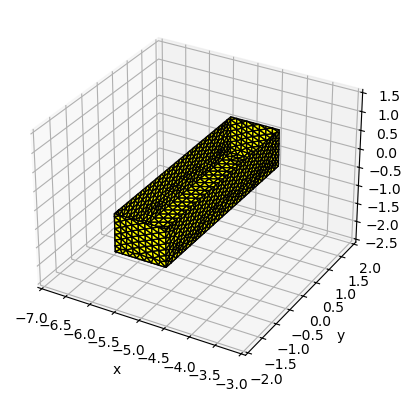

In [280]:
numBodies = 1
bodyDist = 10
bodyLocs = [-0.5*bodyDist, -1.5*bodyDist] #, 3]
mesh_size_factor = 0.16
depth = 2
bodDraft = [1, 1]#, 1]
bodWidth = [1, 1]#, 1]
bodLength = [2, 2]#, 2]

hydrostaticsDict = {}
rect = {}
bodList = []

for nBod in range(numBodies):
    with pygmsh.geo.Geometry() as geom:
        poly1 = geom.add_polygon(
            [[bodyLocs[nBod]-bodWidth[nBod]/2, bodLength[nBod]],
            [bodyLocs[nBod]-bodWidth[nBod]/2,-bodLength[nBod]],
            [bodyLocs[nBod]+bodWidth[nBod]/2,-bodLength[nBod]],
            [bodyLocs[nBod]+bodWidth[nBod]/2,bodLength[nBod]]],mesh_size=mesh_size_factor)
        
        geom.translate(poly1, [0, 0, depth-bodDraft[nBod]])
        geom.extrude(poly1,[0,0,-depth])
        rectMesh = geom.generate_mesh()
        meshObj = load_from_meshio(rectMesh, 'Rect')
        lid_pos = meshObj.lowest_lid_position(f1*nfreq*2*np.pi)
        print(lid_pos)
        #lid_pos = -.05
        lidMesh = meshObj.generate_lid(z=lid_pos)

        # define the floating body
        rect[nBod] = cpt.FloatingBody(mesh=rectMesh, lid_mesh = lidMesh, name="rect"+str(nBod), center_of_mass=(bodyLocs[nBod], 0, 0))
        rect[nBod].keep_immersed_part()

        rect[nBod].center_of_mass = (bodyLocs[nBod], 0, -bodDraft[nBod]/2)
        rect[nBod].rotation_center = rect[nBod].center_of_mass
        rect[nBod].add_translation_dof(name="Heave")
        rect[nBod].add_rotation_dof(name="Pitch")
        #rect[nBod].add_translation_dof(name="Surge")

        rect[nBod].inertia_matrix = rect[nBod].compute_rigid_body_inertia()
        rect[nBod].hydrostatic_stiffness = rect[nBod].immersed_part().compute_hydrostatic_stiffness()

        #print(rect[nBod].inertia_matrix)
        #print(rect[nBod].hydrostatic_stiffness)

        bodList.append(rect[nBod])

all_bodies = cpt.FloatingBody.join_bodies(*bodList)

#allBodies.show_matplotlib()
all_bodies.show_matplotlib()
ndof = all_bodies.nb_dofs

#all_bodies.show()

In [281]:
print(dir(all_bodies))
print(all_bodies.center_of_mass)
print(all_bodies.inertia_matrix)
print(all_bodies.hydrostatic_stiffness)
#all_bodies.show()

['__abstractmethods__', '__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rich_repr__', '__setattr__', '__short_str__', '__sizeof__', '__slotnames__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_infer_rotation_center', '_optional_params_str', '_repr_pretty_', 'add_all_rigid_body_dofs', 'add_dofs_labels_to_matrix', 'add_dofs_labels_to_vector', 'add_rotation_dof', 'add_translation_dof', 'animate', 'assemble_arbitrary_array', 'assemble_regular_array', 'center_of_buoyancy', 'center_of_mass', 'clip', 'clipped', 'cluster_bodies', 'combine_dofs', 'compute_hydrostatic_stiffness', 'compute_hydrostatics', 'compute_rigid_body_inertia', 'copy', 'disp_mass', 'dof_normals', 'dofs', 'each_hydrostatic_stiffness', 'extract_faces

#### Minimum wavelength check
With the frequency vector, wave environment, and geometry mesh all defined, we can now check to make sure they are all suitable to accurately simulate the WEC dynamics.
The `fb.minimal_computable_wavelength` method checks the mesh to determine the minimum wavelength that can be reliably computed using Capytaine.
We compare this value to the minimum wavelength our frequency vector will compute; we want this number to be <u>larger</u> than Capytaine's minimum wavelength.
A warning is printed if this is not the case.
This warning is ignored here because the BEM results have been validated, but can be used as a guide for mesh refinement to ensure accurate BEM results.

In [282]:
min_computable_wavelength = all_bodies.minimal_computable_wavelength
g = 9.81
min_period = 1/(f1*nfreq)
min_wavelength = (g*(min_period)**2)/(2*np.pi)

if min_wavelength < min_computable_wavelength:
    print(f'Warning: Minimum wavelength in frequency spectrum ({min_wavelength}) is smaller'
         f' than the minimum computable wavelength ({min_computable_wavelength}).')

In [283]:
bem_data = wot.run_bem(all_bodies, freq, wave_dirs=0)
# wot.write_netcdf('bem_data.nc', bem_data) # saves BEM data to file


INFO:capytaine.green_functions.delhommeau:Loading tabulation from C:\Users\jtgrasb\AppData\Local\capytaine\Cache\2.2\tabulation_float64_scaled_nemoh3_676_100.0_372_-251.0_1001.npz
INFO:capytaine.bodies.bodies:Clipping rect0_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping mesh_from_meshio_1568 by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.


[14:10:33] WARNING  Using the geometric centroid as the center of gravity (COG).

           WARNING  Using the center of gravity (COG) as the rotation center for hydrostatics.

The resolution of the mesh might be insufficient for omega ranging from 7.854 to 7.854.
This warning appears when the largest panel of this mesh has radius > wavelength/8.


           WARNING  Mesh resolution for 3 problems:                                                                
                    The resolution of the mesh might be insufficient for omega ranging from 7.854 to 7.854.        
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="rect0_immersed"), omega=0.785, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="rect0_immersed"), omega=0.785, water_depth=inf, radiating_dof='rect0__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="rect0_immersed"), omega=0.785, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="rect0_immersed"), omega=1.571, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="rect0_immersed"), omega=1.571, water_depth=inf, radiating_dof='rect0__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="rect0_immersed"), omega=1.571, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0)

In [284]:
nstate_pto = 2 * nfreq # PTO forces
nstate_opt = nstate_pto
pto_ndof = 1

In [285]:
# PTO is simply based on the pitch of the float (assuming pitch is constrained about PTO location)
name = ["PTO_1"]
kinematics = np.array([[0,1]])

controller = None
loss = None

## PTO impedance definition
omega = bem_data.omega.values
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 0.0
drivetrain_friction = 0.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia +
                        drivetrain_friction +
                        1/(1j*omega)*drivetrain_stiffness)

winding_impedance = winding_resistance + 1j*omega*winding_inductance

pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

pto = wot.pto.PTO(pto_ndof, kinematics, controller, pto_impedance, loss, name[0])

In [286]:
hydro_data = wot.add_linear_friction(bem_data, None)
inertia_matrix = hydro_data['inertia_matrix'].values

hydro_data['hydrostatic_stiffness'][1,1] = hydro_data['hydrostatic_stiffness'][0,0]*(bodyDist/2)**2 + hydro_data['hydrostatic_stiffness'][1,1]

# frequency array
f1, nfreq = wot.frequency_parameters(hydro_data.omega.values/(2*np.pi), False)

# check real part of damping diagonal > 0
hydro_data = wot.check_radiation_damping(hydro_data, 1e-6, False)

coeff_dict_heave = {}
coeff_dict_pitch = {}

# standard forces sets up the expected forces based on the BEM data
# intrinsic impedance
coeff_dict_heave['A'] = hydro_data['added_mass'].sel(influenced_dof='rect0__Heave')
coeff_dict_heave['B'] = hydro_data['radiation_damping'].sel(influenced_dof='rect0__Heave')
coeff_dict_heave['K'] = hydro_data['hydrostatic_stiffness'].sel(influenced_dof='rect0__Heave')
coeff_dict_heave['Bf'] = hydro_data['friction'].sel(influenced_dof='rect0__Heave')
coeff_dict_heave['FK'] = hydro_data['Froude_Krylov_force'].sel(influenced_dof='rect0__Heave')
coeff_dict_heave['diff'] = hydro_data['diffraction_force'].sel(influenced_dof='rect0__Heave')

coeff_dict_pitch['A'] = hydro_data['added_mass'].sel(influenced_dof='rect0__Heave')*bodyDist/2 + hydro_data['added_mass'].sel(influenced_dof='rect0__Pitch')
coeff_dict_pitch['B'] = hydro_data['radiation_damping'].sel(influenced_dof='rect0__Heave')*bodyDist/2 + hydro_data['radiation_damping'].sel(influenced_dof='rect0__Pitch')
coeff_dict_pitch['K'] = hydro_data['hydrostatic_stiffness'].sel(influenced_dof='rect0__Heave')*bodyDist/2 + hydro_data['hydrostatic_stiffness'].sel(influenced_dof='rect0__Pitch')
coeff_dict_pitch['Bf'] = hydro_data['friction'].sel(influenced_dof='rect0__Heave')*bodyDist/2 + hydro_data['friction'].sel(influenced_dof='rect0__Pitch')
coeff_dict_pitch['FK'] = hydro_data['Froude_Krylov_force'].sel(influenced_dof='rect0__Heave')*bodyDist/2 + hydro_data['Froude_Krylov_force'].sel(influenced_dof='rect0__Pitch')
coeff_dict_pitch['diff'] = hydro_data['diffraction_force'].sel(influenced_dof='rect0__Heave')*bodyDist/2 + hydro_data['diffraction_force'].sel(influenced_dof='rect0__Pitch')

def add_dof(coeff, dof_name):
    coeff = coeff.assign_coords(influenced_dof = dof_name)
    coeff = coeff.expand_dims(dim = {'influenced_dof':1}, axis=-1)
    return coeff

for coeff in coeff_dict_heave:
    coeff_dict_heave[coeff] = add_dof(coeff_dict_heave[coeff], 'rect0__Heave')

for coeff in coeff_dict_pitch:
    coeff_dict_pitch[coeff] = add_dof(coeff_dict_pitch[coeff], 'rect0__Pitch')

coeff_dict = {}

for coeff in coeff_dict_heave:
    coeff_dict[coeff] = xr.concat([coeff_dict_heave[coeff], coeff_dict_pitch[coeff]], dim='influenced_dof')

coeff_dict['w'] = hydro_data['omega']

rao_transfer_functions = dict()
rao_transfer_functions['radiation'] = (1j*coeff_dict['w']*coeff_dict['B'] + -1*coeff_dict['w']**2*coeff_dict['A'], False)
rao_transfer_functions['friction'] = (1j*coeff_dict['w']*coeff_dict['Bf'], False)

# include zero_freq in hydrostatics
hs = ((coeff_dict['K'] + 0j).expand_dims({"omega": coeff_dict['B'].omega}, 0))
tmp = hs.isel(omega=0).copy(deep=True)
tmp['omega'] = tmp['omega'] * 0
hs = xr.concat([tmp, hs], dim='omega') #, data_vars='minimal')
rao_transfer_functions['hydrostatics'] = (hs, True)

linear_force_functions_about_PTO = dict()
for name, (value, zero_freq) in rao_transfer_functions.items():
    value = value.transpose("omega", "radiating_dof", "influenced_dof")
    value = -1*value  # RHS of equation: ma = Σf
    linear_force_functions_about_PTO[name] = (wot.force_from_rao_transfer_function(value, zero_freq))

# wave excitation
excitation_coefficients = {
    'Froude_Krylov': coeff_dict['FK'],
    'diffraction': coeff_dict['diff'],
}

for name, value in excitation_coefficients.items():
    linear_force_functions_about_PTO[name] = wot.force_from_waves(value)

hydro_data['inertia_matrix'][1,1] = hydro_data['inertia_matrix'][0,0]*(bodyDist/2)**2 + hydro_data['inertia_matrix'][1,1]

#print(bem_data['inertia_matrix'])

bem_data['inertia_matrix'] = hydro_data['inertia_matrix']

#print(bem_data['inertia_matrix'])

#omega = np.expand_dims(wot.frequency(f1, nfreq, False)*2*np.pi, [1,2])
#inertia_matrix = np.expand_dims(hydro_data['inertia_matrix'], 0)
#rao_transfer_function = -1*omega**2*inertia_matrix + 0j

#linear_force_functions_about_PTO['inertia'] = (wot.force_from_rao_transfer_function(rao_transfer_function, False))

print(linear_force_functions_about_PTO) # heave 

[14:10:42] WARNING  Linear damping for DOF "rect0__Heave" has negative or close to zero terms. Shifting up damping 
                    terms [9] to a minimum of 1e-06 N/(m/s)

{'radiation': <function force_from_rao_transfer_function.<locals>.force at 0x0000026F2F567F60>, 'friction': <function force_from_rao_transfer_function.<locals>.force at 0x0000026F2F567D80>, 'hydrostatics': <function force_from_rao_transfer_function.<locals>.force at 0x0000026F38950220>, 'Froude_Krylov': <function force_from_waves.<locals>.force at 0x0000026F1C596CA0>, 'diffraction': <function force_from_waves.<locals>.force at 0x0000026F38950360>}


In [287]:
print(bem_data['hydrostatic_stiffness'])
print(coeff_dict['K'])

<xarray.DataArray 'hydrostatic_stiffness' (influenced_dof: 2, radiating_dof: 2)> Size: 32B
array([[ 3.92400000e+04, -1.22526989e-12],
       [-1.22526989e-12,  3.22919627e+03]])
Coordinates:
    g               float64 8B 9.81
    rho             float64 8B 1.025e+03
    body_name       <U14 56B 'rect0_immersed'
    water_depth     float64 8B inf
    forward_speed   float64 8B 0.0
  * radiating_dof   (radiating_dof) object 16B 'rect0__Heave' 'rect0__Pitch'
  * influenced_dof  (influenced_dof) object 16B 'rect0__Heave' 'rect0__Pitch'
<xarray.DataArray 'hydrostatic_stiffness' (radiating_dof: 2, influenced_dof: 2)> Size: 32B
array([[ 3.92400000e+04,  1.96200000e+05],
       [-1.22526989e-12,  9.84229196e+05]])
Coordinates:
    g               float64 8B 9.81
    rho             float64 8B 1.025e+03
    body_name       <U14 56B 'rect0_immersed'
    water_depth     float64 8B inf
    forward_speed   float64 8B 0.0
  * radiating_dof   (radiating_dof) object 16B 'rect0__Heave' 'rect0__Pitch'


In [288]:


# PTO dynamics forcing function
f_add = {'PTO_1': pto.force_on_wec} | linear_force_functions_about_PTO

# Constraint
f_max = 2000
nsubsteps = 4
pto_max_pos = 30*np.pi/180

def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())

def const_b2_pos(wec, x_wec, x_opt, waves): # surge of float 2 shouldn't have a mean of 0
    length_const = b2_pto_dist(wec, x_wec, x_opt, waves)
    return abs(0.5*bodyDist - length_const).flatten()

constraints = [
    {'type': 'ineq', 'fun': const_f_pto},
#    {'type': 'ineq', 'fun': const_b2_pos},
]

#wec = wot.WEC.from_bem(
#    bem_data,
#    constraints=constraints,
#    friction=None,
#    f_add=f_add,
#)

In [289]:
print(bem_data['inertia_matrix'])

wec = wot.WEC.from_bem(
    bem_data,
    constraints=constraints,
    friction=None,
    f_add=f_add,
)


<xarray.DataArray 'inertia_matrix' (influenced_dof: 2, radiating_dof: 2)> Size: 32B
array([[  4000.        ,     -0.        ],
       [    -0.        , 100551.25236174]])
Coordinates:
    g               float64 8B 9.81
    rho             float64 8B 1.025e+03
    body_name       <U14 56B 'rect0_immersed'
    water_depth     float64 8B inf
    forward_speed   float64 8B 0.0
  * radiating_dof   (radiating_dof) object 16B 'rect0__Heave' 'rect0__Pitch'
  * influenced_dof  (influenced_dof) object 16B 'rect0__Heave' 'rect0__Pitch'


[14:10:43] WARNING  Linear damping for DOF "rect0__Heave" has negative or close to zero terms. Shifting up damping 
                    terms [9] to a minimum of 1e-06 N/(m/s)

In [290]:
obj_fun = pto.average_power
#nstate_opt = 2*2*nfreq

options = {'maxiter': 200}
scale_x_wec = 1e0
scale_x_opt = 1e-2
scale_obj = 1e-2

results = wec.solve(
    waves, 
    obj_fun, 
    nstate_opt,
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    )

opt_average_power = results[0].fun
print(f'Optimal average mechanical power: {opt_average_power} W')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:756: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.98e-02, 3.85e+00, 1.59e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.89e-02, 3.83e+00, 1.57e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [9.45e-02, 3.72e+00, 1.48e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [7.32e-02, 3.21e+00, 1.07e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.64e-02, 1.06e+00, 8.94e-03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [4.21e-02, 9.31e-01, 3.64e-03]
INFO:w

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0022190564009886486
            Iterations: 11
            Function evaluations: 12
            Gradient evaluations: 11
Optimal average mechanical power: -0.22190564009886485 W


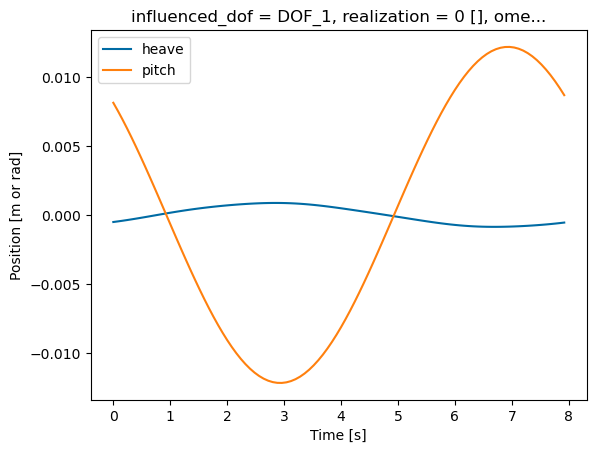

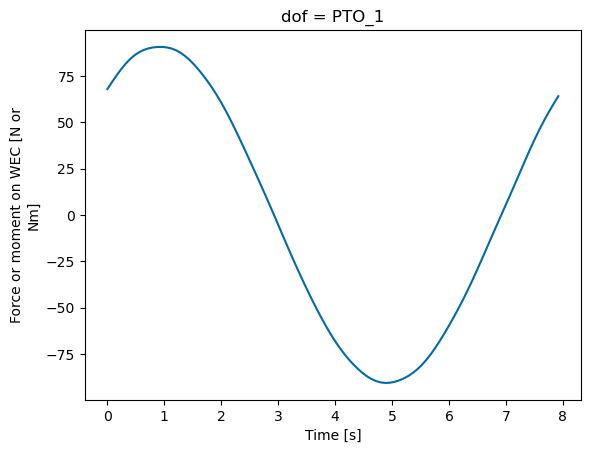

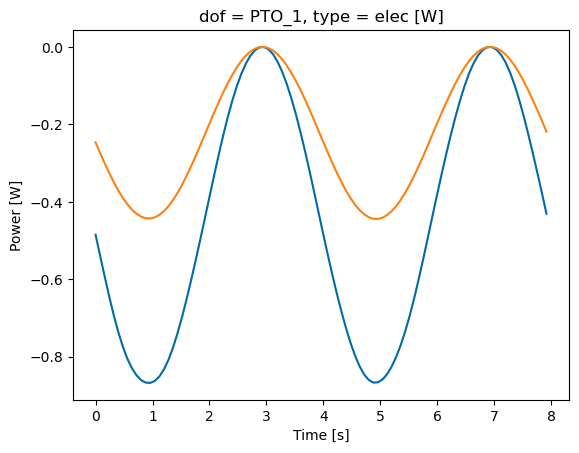

In [291]:
x_wec, x_opt = wec.decompose_state(results[0].x)

nsubsteps = 5
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)

plt.figure()
wec_tdom[0]['pos'][0].plot(label='heave')
wec_tdom[0]['pos'][1].plot(label='pitch')
plt.legend()

plt.figure()
pto_tdom[0]['force'].plot()

plt.figure()
pto_tdom[0]['power'].loc['mech',:,:].plot()
pto_tdom[0]['power'].loc['elec',:,:].plot()



<xarray.DataArray 'type' (type: 6)> Size: 48B
array(['radiation', 'friction', 'hydrostatics', 'Froude_Krylov', 'diffraction',
       'PTO_1'], dtype=object)
Coordinates:
    realization  int32 4B 0
    omega        float64 8B 7.854
    freq         float64 8B 1.25
    period       float64 8B 0.8
  * type         (type) object 48B 'radiation' 'friction' ... 'PTO_1'
Attributes:
    long_name:  Type


Text(0, 0.5, 'pitch hydrostatics')

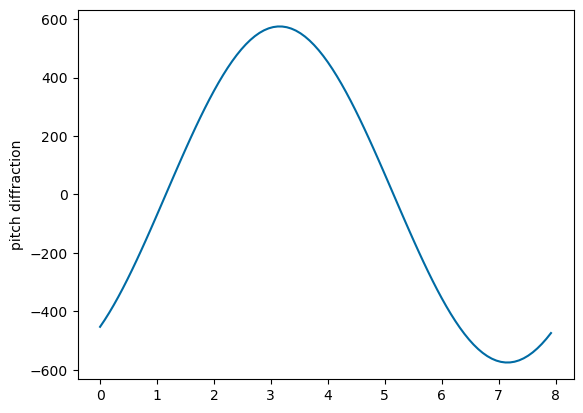

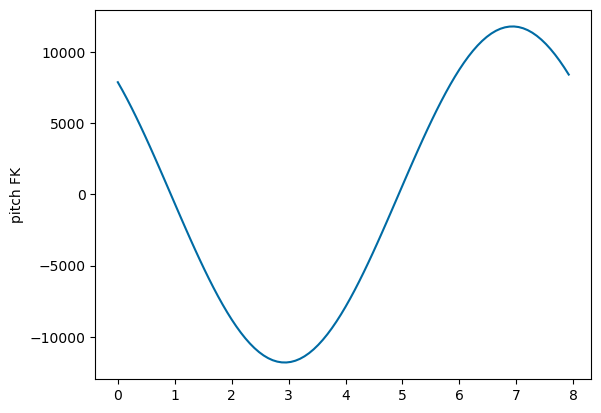

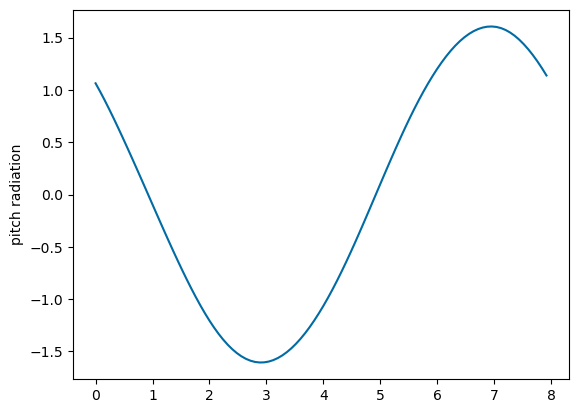

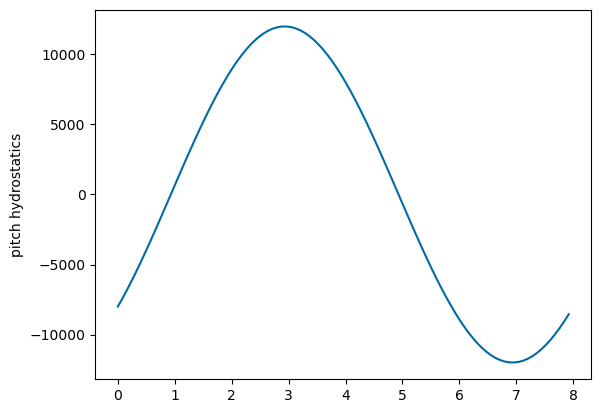

In [292]:
print(wec_tdom[0]['force']['type'])

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][1].sel(type='diffraction')))
plt.ylabel('pitch diffraction')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][1].sel(type='Froude_Krylov')))
plt.ylabel('pitch FK')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][1].sel(type='radiation')))
plt.ylabel('pitch radiation')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'][1].sel(type='hydrostatics')))
plt.ylabel('pitch hydrostatics')